# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../Pendulums.jl"); using .Pendulums
includet("../location_scale_tdist.jl"); using .location_scale_tdist

In [2]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.2
sys_mnoise_sd = 1e-2
sys_ulims = (-40., 40.)
Δt = 0.2

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], 0.0018009018133852924, 0.0, (-40.0, 40.0), 0.2, 2.0, 0.5, 0.2, 0.01)

In [3]:
N = 100
tsteps = range(0.0, step=Δt, length=N)

0.0:0.2:19.8

In [4]:
# Inputs
A  = rand(10)*300 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [5]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

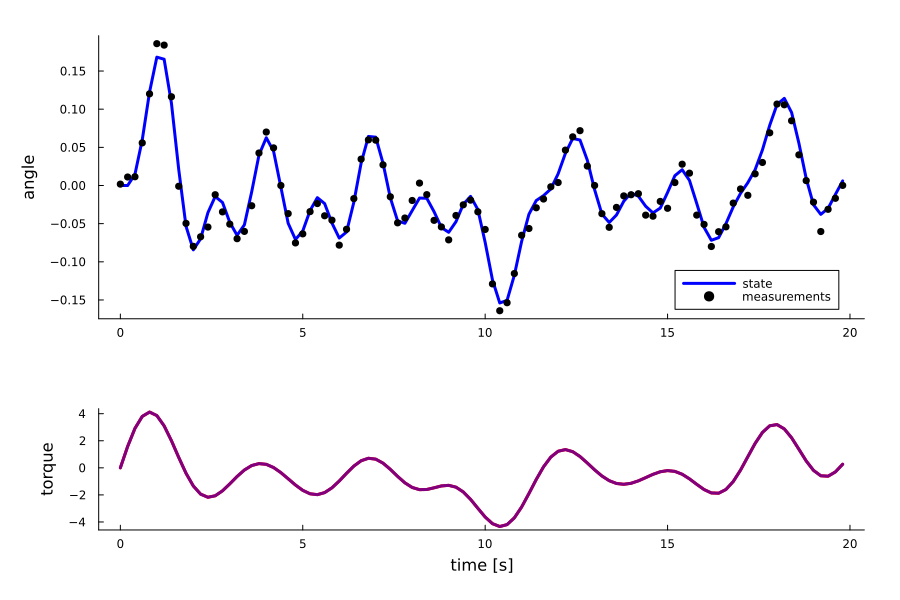

In [6]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Experiments

In [7]:
# Experiment specification 
N = 200
tsteps = range(0.0, step=Δt, length=N)
T = 10

# NARX basis settings
H = 2
Ly = 2
Lu = 2
M = size(pol(zeros(Ly+Lu+1), degree=H),1);

# System specification
init_state = [0.0, 0.0];

# Agent specification
α0 = 10.0
β0 = 1.0
μ0 = zeros(M)
Λ0 = diagm(ones(M))
λ = 1e-3

0.001

### Expected Free Energy minimization

In [8]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Set goal priors for time horizon
goals = [Normal(3.14, 1.0) for t in 1:T]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
F_EFE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_EFE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[k] = agent.free_energy
    push!(μ_EFE, agent.μ )
    push!(Λ_EFE, agent.Λ )
    push!(α_EFE, agent.α )
    push!(β_EFE, agent.β )
    
    # Optimal control
    policy = minimizeEFE(agent, goals, control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_EFE[k+1])
    z_EFE[:,k] = pendulum.state
    
end

Progress:   1%|▍                                        |  ETA: 0:15:44

Progress:  11%|████▌                                    |  ETA: 0:01:31

Progress:  12%|████▉                                    |  ETA: 0:01:25

Progress:  13%|█████▍                                   |  ETA: 0:01:18

Progress:  14%|█████▊                                   |  ETA: 0:01:14

Progress:  14%|██████                                   |  ETA: 0:01:11

Progress:  15%|██████▏                                  |  ETA: 0:01:10

Progress:  16%|██████▍                                  |  ETA: 0:01:08

Progress:  16%|██████▌                                  |  ETA: 0:01:06

Progress:  16%|██████▊                                  |  ETA: 0:01:05

Progress:  17%|███████                                  |  ETA: 0:01:03

Progress:  18%|███████▏                                 |  ETA: 0:01:02

Progress:  18%|███████▍                                 |  ETA: 0:01:02

Progress:  18%|███████▋                                 |  ETA: 0:01:00

Progress:  19%|███████▊                                 |  ETA: 0:02:07

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/wmkouw/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148


Progress:  20%|████████                                 |  ETA: 0:02:14

Progress:  20%|████████▎                                |  ETA: 0:02:52

Progress:  20%|████████▍                                |  ETA: 0:02:48

Progress:  21%|████████▋                                |  ETA: 0:02:44

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/wmkouw/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148


Progress:  22%|████████▉                                |  ETA: 0:02:42

Progress:  22%|█████████                                |  ETA: 0:02:39

Progress:  22%|█████████▎                               |  ETA: 0:02:35

Progress:  23%|█████████▍                               |  ETA: 0:02:33

Progress:  24%|█████████▋                               |  ETA: 0:02:29

Progress:  24%|█████████▉                               |  ETA: 0:02:25

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/wmkouw/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /home/wmkouw/.julia/packages/LineSearches/G1LRk/src/hagerzhang.jl:148


Progress:  29%|███████████▉                             |  ETA: 0:02:00

Progress:  34%|██████████████                           |  ETA: 0:01:39

Progress:  39%|████████████████                         |  ETA: 0:01:21

Progress:  40%|████████████████▎                        |  ETA: 0:01:20

Progress:  41%|████████████████▊                        |  ETA: 0:01:16

Progress:  42%|█████████████████▎                       |  ETA: 0:01:13

Progress:  43%|█████████████████▋                       |  ETA: 0:01:10

Progress:  44%|█████████████████▉                       |  ETA: 0:01:09

Progress:  44%|██████████████████▎                      |  ETA: 0:01:07

Progress:  50%|████████████████████▎                    |  ETA: 0:00:56

Progress:  50%|████████████████████▌                    |  ETA: 0:00:55

Progress:  50%|████████████████████▊                    |  ETA: 0:00:54

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:51

Progress:  52%|█████████████████████▌                   |  ETA: 0:00:50

Progress:  56%|██████████████████████▊                  |  ETA: 0:00:45

Progress:  56%|███████████████████████                  |  ETA: 0:00:44

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:42

Progress:  58%|████████████████████████                 |  ETA: 0:00:40

Progress:  59%|████████████████████████▎                |  ETA: 0:00:40

Progress:  60%|████████████████████████▍                |  ETA: 0:00:39

Progress:  60%|████████████████████████▊                |  ETA: 0:00:37

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:35

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:34

Progress:  64%|██████████████████████████               |  ETA: 0:00:33

Progress:  64%|██████████████████████████▌              |  ETA: 0:00:32

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:31

Progress:  66%|██████████████████████████▉              |  ETA: 0:00:31

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:30

Progress:  68%|███████████████████████████▋             |  ETA: 0:00:28

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:28

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:27

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:26

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:25

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:24

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:23

Progress:  72%|█████████████████████████████▊           |  ETA: 0:00:23

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:20

Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:19

Progress:  78%|████████████████████████████████         |  ETA: 0:00:17

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:17

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:16

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:16

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:16

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:15

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:12

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:11

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:07

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:07

Progress:  92%|█████████████████████████████████████▌   |  ETA: 0:00:06

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:06

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:05

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


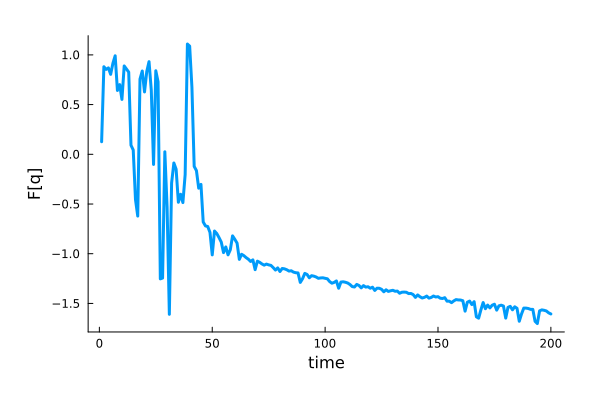

In [9]:
plot(F_EFE, xlabel="time", ylabel="F[q]")

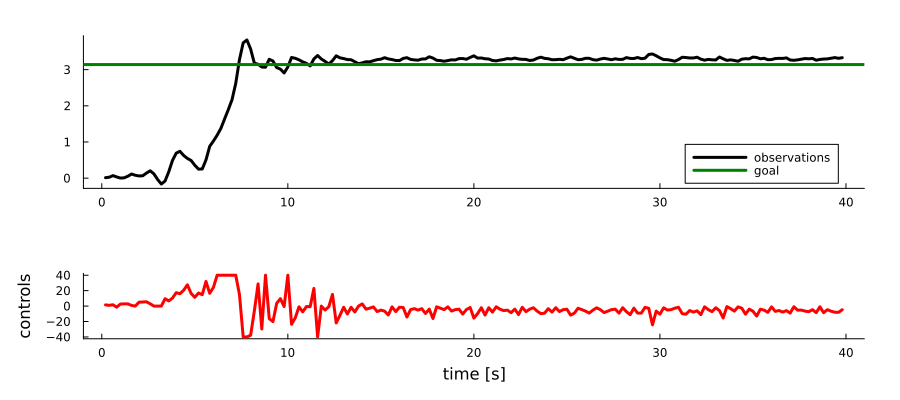

In [10]:
p1 = plot(tsteps[2:end], y_EFE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
# vline!([cut_gvar], color="orange", label="change in goal prior var")
p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [11]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/NARX-EFE-1Pendulum-trial.png"

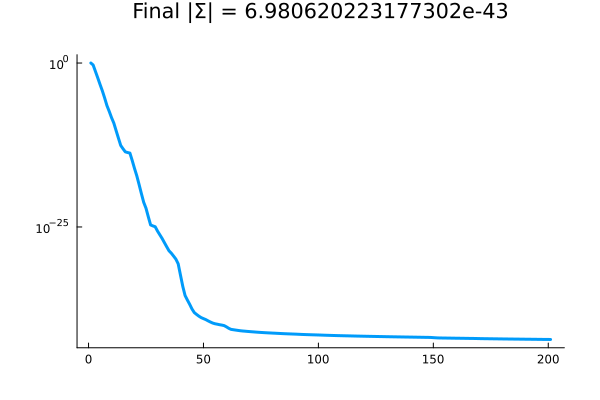

In [12]:
dSθ_EFE = det.(inv.(Λ_EFE))
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/NARX-EFE-1Pendulum-planning.gif")
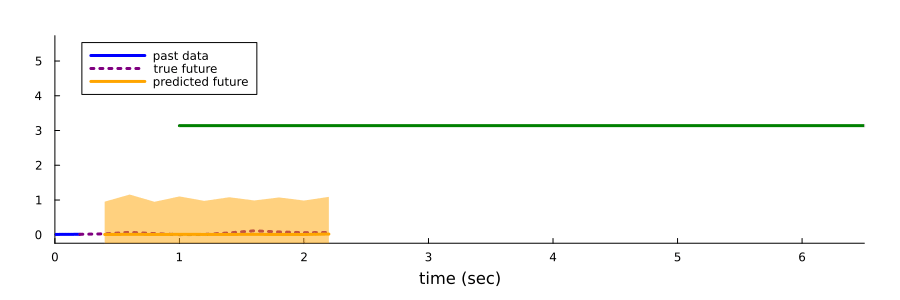

In [13]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

### Mean Squared Error minimization

In [14]:
T = 10

# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Define setpoint
goals = [Normal(3.14, 1.0) for t in 1:T]                     

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_MSE = zeros(N)
z_MSE = zeros(2,N)
u_MSE = zeros(N+T)
μ_MSE = [μ0]
Λ_MSE = [Λ0]
α_MSE = [α0]
β_MSE = [β0]
F_MSE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_MSE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    F_MSE[k] = agent.free_energy
    push!(μ_MSE, agent.μ )
    push!(Λ_MSE, agent.Λ )
    push!(α_MSE, agent.α )
    push!(β_MSE, agent.β )
    
    # Optimal control
    policy = minimizeMSE(agent, goals, control_lims=sys_ulims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_MSE[k+1])
    z_MSE[:,k] = pendulum.state
    
end

Progress:   1%|▍                                        |  ETA: 0:03:24

Progress:   2%|▉                                        |  ETA: 0:01:48

Progress:   3%|█▎                                       |  ETA: 0:01:15

Progress:   8%|███▎                                     |  ETA: 0:02:57

Progress:   8%|███▌                                     |  ETA: 0:02:48

Progress:   9%|███▊                                     |  ETA: 0:02:39

Progress:  10%|███▉                                     |  ETA: 0:02:31

Progress:  10%|████▏                                    |  ETA: 0:02:24

Progress:  10%|████▎                                    |  ETA: 0:02:18

Progress:  11%|████▌                                    |  ETA: 0:02:12

Progress:  12%|████▊                                    |  ETA: 0:02:07

Progress:  12%|████▉                                    |  ETA: 0:02:04

Progress:  12%|█████▏                                   |  ETA: 0:02:00

Progress:  13%|█████▍                                   |  ETA: 0:01:57

Progress:  14%|█████▌                                   |  ETA: 0:01:53

Progress:  14%|█████▊                                   |  ETA: 0:01:50

Progress:  14%|██████                                   |  ETA: 0:01:46

Progress:  15%|██████▏                                  |  ETA: 0:01:43

Progress:  16%|██████▌                                  |  ETA: 0:01:38

Progress:  16%|██████▊                                  |  ETA: 0:01:37

Progress:  17%|███████                                  |  ETA: 0:01:35

Progress:  18%|███████▏                                 |  ETA: 0:01:33

Progress:  18%|███████▍                                 |  ETA: 0:01:31

Progress:  18%|███████▋                                 |  ETA: 0:01:28

Progress:  19%|███████▊                                 |  ETA: 0:01:26

Progress:  20%|████████                                 |  ETA: 0:01:24

Progress:  20%|████████▎                                |  ETA: 0:01:23

Progress:  20%|████████▍                                |  ETA: 0:01:22

Progress:  21%|████████▋                                |  ETA: 0:01:20

Progress:  22%|████████▉                                |  ETA: 0:01:19

Progress:  22%|█████████                                |  ETA: 0:01:17

Progress:  23%|█████████▍                               |  ETA: 0:01:29

Progress:  24%|█████████▋                               |  ETA: 0:01:27

Progress:  24%|█████████▉                               |  ETA: 0:01:25

Progress:  24%|██████████                               |  ETA: 0:01:23

Progress:  25%|██████████▎                              |  ETA: 0:01:21

Progress:  26%|██████████▌                              |  ETA: 0:01:19

Progress:  26%|██████████▉                              |  ETA: 0:01:16

Progress:  27%|███████████▏                             |  ETA: 0:01:17

Progress:  28%|███████████▎                             |  ETA: 0:01:16

Progress:  28%|███████████▌                             |  ETA: 0:01:14

Progress:  29%|███████████▉                             |  ETA: 0:01:11

Progress:  30%|████████████▎                            |  ETA: 0:01:16

Progress:  30%|████████████▌                            |  ETA: 0:01:15

Progress:  31%|████████████▊                            |  ETA: 0:01:14

Progress:  32%|████████████▉                            |  ETA: 0:01:13

Progress:  32%|█████████████▏                           |  ETA: 0:01:14

Progress:  32%|█████████████▍                           |  ETA: 0:01:21

Progress:  33%|█████████████▌                           |  ETA: 0:01:26

Progress:  34%|█████████████▊                           |  ETA: 0:01:29

Progress:  34%|██████████████                           |  ETA: 0:01:29

Progress:  34%|██████████████▏                          |  ETA: 0:01:29

Progress:  35%|██████████████▍                          |  ETA: 0:01:29

Progress:  36%|██████████████▌                          |  ETA: 0:01:28

Progress:  36%|██████████████▊                          |  ETA: 0:01:39

Progress:  36%|███████████████                          |  ETA: 0:01:40

Progress:  37%|███████████████▏                         |  ETA: 0:01:39

Progress:  38%|███████████████▍                         |  ETA: 0:01:38

Progress:  38%|███████████████▋                         |  ETA: 0:01:37

Progress:  38%|███████████████▊                         |  ETA: 0:01:36

Progress:  39%|████████████████                         |  ETA: 0:01:37

Progress:  40%|████████████████▎                        |  ETA: 0:01:36

Progress:  40%|████████████████▍                        |  ETA: 0:01:35

Progress:  40%|████████████████▋                        |  ETA: 0:01:45

Progress:  41%|████████████████▊                        |  ETA: 0:01:45

Progress:  42%|█████████████████                        |  ETA: 0:01:44

Progress:  42%|█████████████████▎                       |  ETA: 0:01:43

Progress:  42%|█████████████████▍                       |  ETA: 0:01:42

Progress:  43%|█████████████████▋                       |  ETA: 0:01:41

Progress:  44%|█████████████████▉                       |  ETA: 0:01:41

Progress:  44%|██████████████████                       |  ETA: 0:01:40

Progress:  44%|██████████████████▎                      |  ETA: 0:01:42

Progress:  45%|██████████████████▌                      |  ETA: 0:01:44

Progress:  46%|██████████████████▋                      |  ETA: 0:01:42

Progress:  46%|██████████████████▉                      |  ETA: 0:01:40

Progress:  46%|███████████████████▏                     |  ETA: 0:01:44

Progress:  47%|███████████████████▎                     |  ETA: 0:01:52

Progress:  48%|███████████████████▌                     |  ETA: 0:01:50

Progress:  48%|███████████████████▋                     |  ETA: 0:01:50

Progress:  48%|███████████████████▉                     |  ETA: 0:01:49

Progress:  49%|████████████████████▏                    |  ETA: 0:01:48

Progress:  50%|████████████████████▎                    |  ETA: 0:01:46

Progress:  50%|████████████████████▌                    |  ETA: 0:01:45

Progress:  50%|████████████████████▊                    |  ETA: 0:01:44

Progress:  51%|████████████████████▉                    |  ETA: 0:01:42

Progress:  52%|█████████████████████▏                   |  ETA: 0:01:43

Progress:  52%|█████████████████████▍                   |  ETA: 0:01:42

Progress:  52%|█████████████████████▌                   |  ETA: 0:01:41

Progress:  53%|█████████████████████▊                   |  ETA: 0:01:40

Progress:  54%|█████████████████████▉                   |  ETA: 0:01:38

Progress:  54%|██████████████████████▏                  |  ETA: 0:01:37

Progress:  54%|██████████████████████▍                  |  ETA: 0:01:35

Progress:  55%|██████████████████████▌                  |  ETA: 0:01:34

Progress:  56%|██████████████████████▊                  |  ETA: 0:01:33

Progress:  56%|███████████████████████                  |  ETA: 0:01:32

Progress:  56%|███████████████████████▏                 |  ETA: 0:01:31

Progress:  57%|███████████████████████▍                 |  ETA: 0:01:29

Progress:  58%|███████████████████████▋                 |  ETA: 0:01:28

Progress:  58%|███████████████████████▊                 |  ETA: 0:01:26

Progress:  58%|████████████████████████                 |  ETA: 0:01:26

Progress:  59%|████████████████████████▎                |  ETA: 0:01:25

Progress:  60%|████████████████████████▍                |  ETA: 0:01:25

Progress:  60%|████████████████████████▋                |  ETA: 0:01:24

Progress:  60%|████████████████████████▊                |  ETA: 0:01:23

Progress:  61%|█████████████████████████                |  ETA: 0:01:21

Progress:  62%|█████████████████████████▎               |  ETA: 0:01:20

Progress:  62%|█████████████████████████▍               |  ETA: 0:01:19

Progress:  62%|█████████████████████████▋               |  ETA: 0:01:18

Progress:  63%|█████████████████████████▉               |  ETA: 0:01:16

Progress:  64%|██████████████████████████               |  ETA: 0:01:15

Progress:  64%|██████████████████████████▎              |  ETA: 0:01:14

Progress:  64%|██████████████████████████▌              |  ETA: 0:01:12

Progress:  65%|██████████████████████████▋              |  ETA: 0:01:16

Progress:  66%|██████████████████████████▉              |  ETA: 0:01:15

Progress:  66%|███████████████████████████              |  ETA: 0:01:16

Progress:  66%|███████████████████████████▎             |  ETA: 0:01:15

Progress:  67%|███████████████████████████▌             |  ETA: 0:01:14

Progress:  68%|███████████████████████████▋             |  ETA: 0:01:13

Progress:  68%|███████████████████████████▉             |  ETA: 0:01:12

Progress:  68%|████████████████████████████▏            |  ETA: 0:01:13

Progress:  69%|████████████████████████████▎            |  ETA: 0:01:12

Progress:  70%|████████████████████████████▌            |  ETA: 0:01:10

Progress:  70%|████████████████████████████▊            |  ETA: 0:01:10

Progress:  70%|████████████████████████████▉            |  ETA: 0:01:10

Progress:  71%|█████████████████████████████▏           |  ETA: 0:01:08

Progress:  72%|█████████████████████████████▍           |  ETA: 0:01:07

Progress:  72%|█████████████████████████████▌           |  ETA: 0:01:05

Progress:  72%|█████████████████████████████▊           |  ETA: 0:01:04

Progress:  73%|█████████████████████████████▉           |  ETA: 0:01:03

Progress:  74%|██████████████████████████████▏          |  ETA: 0:01:02

Progress:  74%|██████████████████████████████▍          |  ETA: 0:01:00

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:59

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:59

Progress:  76%|███████████████████████████████          |  ETA: 0:00:57

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:56

Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:55

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:54

Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:53

Progress:  78%|████████████████████████████████         |  ETA: 0:00:52

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:51

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:50

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:51

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:50

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:49

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:47

Progress:  82%|█████████████████████████████████▍       |  ETA: 0:00:46

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:45

Progress:  82%|█████████████████████████████████▉       |  ETA: 0:00:43

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:42

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:41

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:40

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:38

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:37

Progress:  86%|███████████████████████████████████      |  ETA: 0:00:36

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:34

Progress:  86%|███████████████████████████████████▌     |  ETA: 0:00:33

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:32

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:31

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:30

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:28

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:27

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:25

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:24

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:23

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:22

Progress:  92%|█████████████████████████████████████▌   |  ETA: 0:00:20

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:19

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:18

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:17

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:15

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:14

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:13

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:12

Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:11

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:09

Progress:  96%|███████████████████████████████████████▋ |  ETA: 0:00:08

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:07

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:06

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:05

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:04

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:03:51


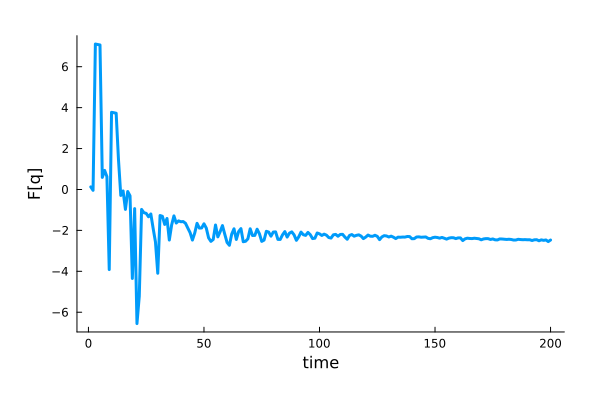

In [15]:
plot(F_MSE, xlabel="time", ylabel="F[q]")

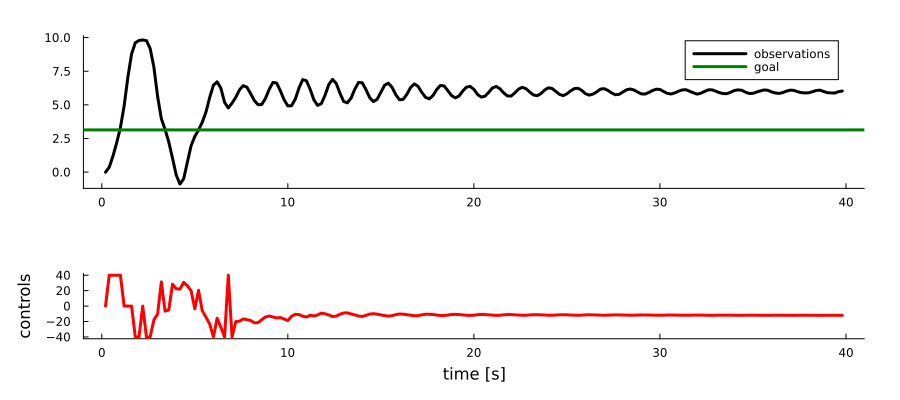

In [16]:
p1 = plot(tsteps[2:end], y_MSE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(tsteps[2:end], u_MSE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [17]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/NARX-MSE-1Pendulum-trial.png"

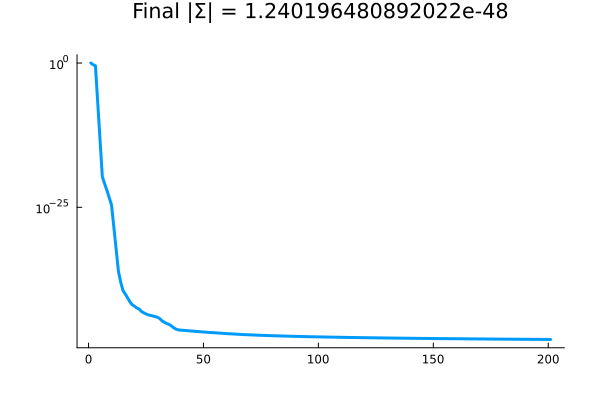

In [18]:
dSθ_MSE = det.(inv.(Λ_MSE))
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="Final |Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/NARX-MSE-1Pendulum-planning.gif")
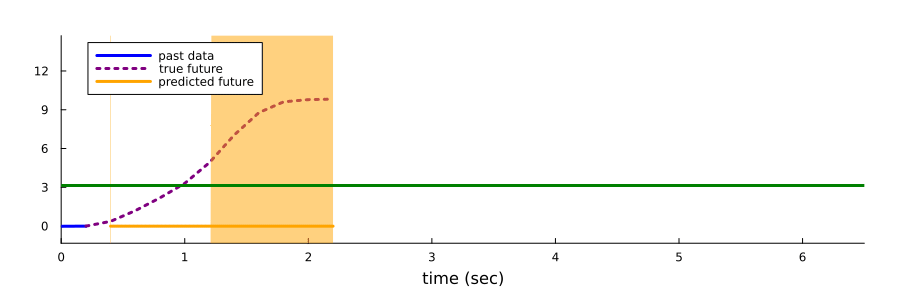

In [19]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)

### Comparisons

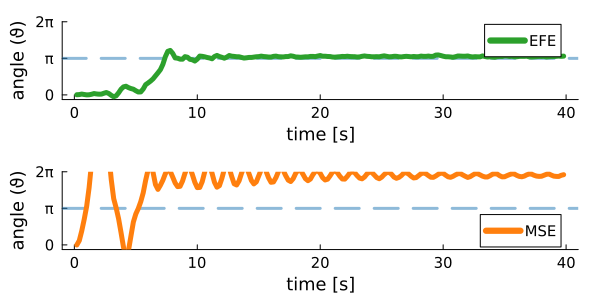

In [20]:
p1 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_MSE[2:end], linewidth=5, color=palette(:tab10)[2], label="MSE")

p2 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_EFE[2:end], linewidth=5, color=palette(:tab10)[3], label="EFE")

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

In [21]:
savefig("figures/compare-trials.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/compare-trials.png"

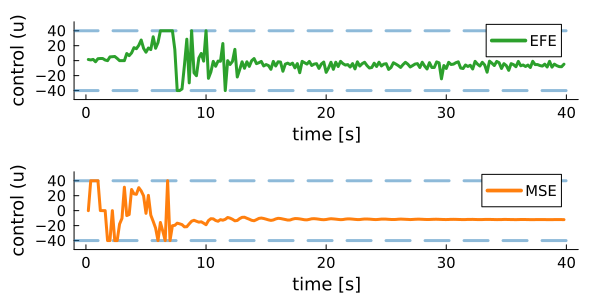

In [22]:
p1 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_MSE[2:end-T], linewidth=3, color=palette(:tab10)[2], label="MSE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

p2 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_EFE[2:end-T], linewidth=3, color=palette(:tab10)[3], label="EFE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

In [23]:
savefig("figures/compare-controls.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/notebooks/figures/compare-controls.png"

In [24]:
println("Final sum of eigenvalues of Σ_θ for MSE = $final_dSθ_MSE")
println("Final sum of eigenvalues of Σ_θ for EFE = $final_dSθ_EFE")

Final sum of eigenvalues of Σ_θ for MSE = 1.240196480892022e-48
Final sum of eigenvalues of Σ_θ for EFE = 6.980620223177302e-43


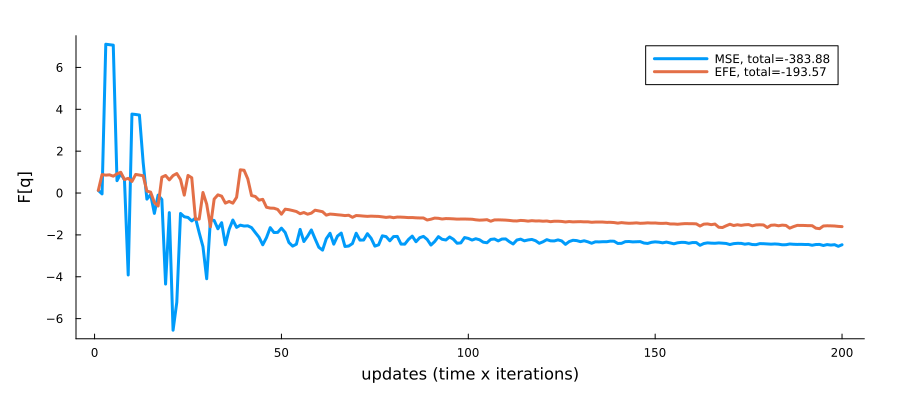

In [25]:
sF_MSE = round(sum(F_MSE[:]), digits=2)
sF_EFE = round(sum(F_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(F_MSE[:], label="MSE, total=$sF_MSE")
plot!(F_EFE[:], label="EFE, total=$sF_EFE")

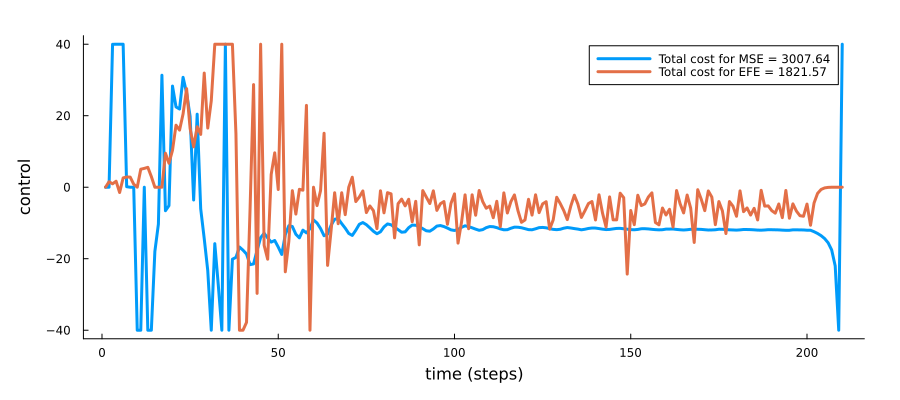

In [26]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

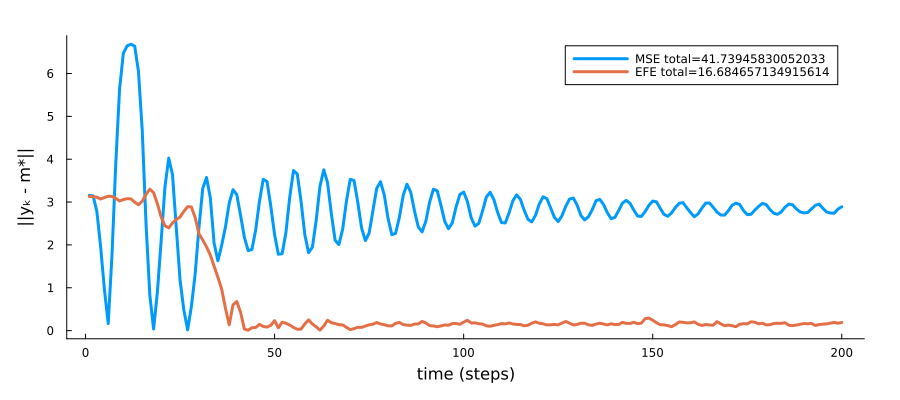

In [27]:
J_MSE = [norm(y_MSE[k] - mean(goals[1]),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goals[1]),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goals[1]),2)
sJ_EFE = norm(y_EFE .- mean(goals[1]),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")